# Momentum Strategy

In [82]:
from typing import Dict, Optional
import pandas as pd
import plotly.express as px
from data.data_loader import PykrxDataLoader
from simulation.account import Account
from simulation.broker import Broker
from simulation.utility import get_lookback_fromdate
from simulation.utility import rebalance
from simulation.metric import cagr, mdd, sharpe_ratio, sortino_ratio

In [1]:
def calculate_momentum(ohlcv_data: pd.DataFrame,
                       lookback_period: int,
                       skip_period: int,
                       momentum: str) -> pd.DataFrame:
    # 종가 데이터 처리
    data = ohlcv_data[['high', 'close', 'ticker']].reset_index().set_index(
        ['ticker', 'date']).unstack(level=0)
    close_data = data['close']

    # 모멘텀 계산하기
    if momentum == "returns":
        momentum_data = close_data.shift(periods=skip_period).rolling(
            window=lookback_period).apply(lambda x: x[-1] / x[0] - 1) #skip_period만큼 전체 데이터를 shift(아래로 이동, 기존 위치는 NaN으로 처리됨)
    elif momentum == '52wh':
        highest_highs = data['high'].shift(periods=skip_period).rolling(window=lookback_period).max() #기간 내 최고가 정의
        momentum_data = close_data.shift(periods=skip_period) / highest_highs #52주 최고가 모멘텀 정의
    else:
        raise ValueError

    return momentum_data


def get_momentum_weights(strategy_name: str,
                         momentum_data: pd.DataFrame,
                         buying_ratio: float,
                         buying_criteria: float) -> Optional[Dict]:
    # 데이터 결측치 여부 점검
    if momentum_data.isnull().values.any():
        return None

    # 매수 대상 선정
    if strategy_name == 'relative' or strategy_name == '52wh': #상대 모멘텀 or 52주 모멘텀이면,
        top_quantile = momentum_data.quantile(1 - buying_ratio) # ex] (1-buying_ratio)=0.9 -> 0.9분위수(상위 10%)
        stocks_to_buy = momentum_data[momentum_data >= top_quantile].index.to_list()
    elif strategy_name == 'absolute': #절대 모멘텀이면,
        stocks_to_buy = momentum_data[momentum_data > buying_criteria].index.to_list()
    elif strategy_name == 'dual': #듀얼 모멘텀이면,
        top_quantile = momentum_data.quantile(1 - buying_ratio)
        relative_result = set(momentum_data[momentum_data >= top_quantile].index)
        absolute_result = set(momentum_data[momentum_data > buying_criteria].index)
        stocks_to_buy = list(relative_result & absolute_result)
    else:
        raise ValueError

    # 매수 비율 할당
    weights = 1 / len(stocks_to_buy) if stocks_to_buy else 0
    portfolio = {ticker: weights if ticker in stocks_to_buy else 
                 0.0 for ticker in momentum_data.index}

    return portfolio

NameError: name 'pd' is not defined

In [84]:
def simulate_momentum(ohlcv_data: pd.DataFrame,
                      lookback_period: int,
                      skip_period: int,
                      strategy_name: str,
                      buying_ratio: float = 0.1,
                      buying_criteria: float = 0.0) -> Account:
    # 계좌 및 브로커 선언
    account = Account(initial_cash=100000000)
    broker = Broker()

    # 모멘텀 계산
    momentum = 'returns' if strategy_name != '52wh' else '52wh'
    momentum_data = calculate_momentum(ohlcv_data=ohlcv_data,
                                       lookback_period=lookback_period,
                                       skip_period=skip_period,
                                       momentum=momentum)

    for date, ohlcv in ohlcv_data.groupby(['date']):
        date = pd.to_datetime(date[0])
        print(date.date())

        # 주문 집행 및 계좌 갱신
        transactions = broker.process_order(dt=date, data=ohlcv, orders=account.orders)
        account.update_position(transactions=transactions)
        account.update_portfolio(dt=date, data=ohlcv)
        account.update_order()

        # 포트폴리오 구성
        momentum_data_slice = momentum_data.loc[date] # 날짜 데이터 따로 정의
        weights = get_momentum_weights(strategy_name=strategy_name,
                                       momentum_data=momentum_data_slice,
                                       buying_ratio=buying_ratio,
                                       buying_criteria=buying_criteria)

        print(f'Portfolio: {weights}')
        if weights is None:
            continue

        # 주문 생성
        rebalance(dt=date, data=ohlcv, account=account, weights=weights)

    return account

In [85]:
# 데이터 기간 설정
fromdate = '2020-01-01'
todate = '2025-01-11'

# 투자할 종목 후보 정의
ticker_list = ['005930', '000660', '207940',
               '051910', '006400', '005380',
               '000270', '005490', '035420']

# Lookback,Skip 기간 정의
lookback = 6
offset = 1

# 1달 주기 데이터 분석
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=lookback+offset, freq='m')

# 데이터 불러오기
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)
ohlcv_data.head(5)

/Users/jh/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pykrx/stock/stock_api.py:46: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/Users/jh/Desktop/PyRA/data/data_loader.py:116: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.



,ticker,open,high,low,close,volume
date,,,,,,
2019-07-31,000270,44000,44300,41250,43750,21335201
2019-08-31,000270,43750,44100,40850,43700,18977505
2019-09-30,000270,43000,46900,42700,45600,20388628
2019-10-31,000270,45200,45900,39500,42550,21557754
2019-11-30,000270,42150,44800,41800,43250,18030352


In [86]:
# (단순)상대 모멘텀 전략
# 상위 N% 매수 비율 정의
ratio = 0.2
# 전략 정의
strategy = 'relative'  # {relative, absolute, dual, 52wh}
# 상대모멘텀 전략 실행
account_relative = simulate_momentum(ohlcv_data=ohlcv_data,
                                     lookback_period=lookback,
                                     skip_period=offset,
                                     strategy_name=strategy,
                                     buying_ratio=ratio)

2019-07-31
Portfolio: None
2019-08-31
Portfolio: None
2019-09-30
Portfolio: None
2019-10-31
Portfolio: None
2019-11-30
Portfolio: None
2019-12-31
Portfolio: None
2020-01-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.5, '051910': 0.0, '207940': 0.5}
2020-02-29
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.5, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2020-03-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2020-04-30
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2020-05-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2020-06-30
Portfolio: {'000270': 0.0, '000660': 

/var/folders/1j/d_cg9rn93xn390pf9vs669bh0000gn/T/ipykernel_17959/1045288913.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [87]:
# (중기)상대 모멘텀
# 기간 정의
lookback = 3
offset = 6
# 기간을 고려한 데이터 시작 날짜 가져오기
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=lookback+offset, freq='m')
# 데이터 불러오기
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)
# 상위 N% 매수 비율 정의
ratio = 0.2
# 전략 정의
strategy = 'relative'  # {relative, absolute, dual, 52wh}
# 중기모멘텀 전략 실행
account_intermediate = simulate_momentum(ohlcv_data=ohlcv_data,
                                         lookback_period=lookback,
                                         skip_period=offset,
                                         strategy_name=strategy,
                                         buying_ratio=ratio)

/Users/jh/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pykrx/stock/stock_api.py:46: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



2019-04-30
Portfolio: None
2019-05-31
Portfolio: None
2019-06-30
Portfolio: None
2019-07-31
Portfolio: None
2019-08-31
Portfolio: None
2019-09-30
Portfolio: None
2019-10-31
Portfolio: None
2019-11-30
Portfolio: None
2019-12-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.5, '005490': 0.0, '005930': 0.5, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2020-01-31
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.5, '051910': 0.0, '207940': 0.0}
2020-02-29
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.5, '051910': 0.0, '207940': 0.0}
2020-03-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.5, '051910': 0.0, '207940': 0.5}
2020-04-30
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.5, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940':

/Users/jh/Desktop/PyRA/data/data_loader.py:116: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.

/var/folders/1j/d_cg9rn93xn390pf9vs669bh0000gn/T/ipykernel_17959/1045288913.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [88]:
# 절대 모멘텀
# 나머지 과정 동일
lookback = 6
offset = 1
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=lookback+offset, freq='m')
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)
criteria = 0.0 # 매수 기준(absolute)
strategy = 'absolute'  # {relative, absolute, dual, 52wh}
# 절대모멘텀 전략 실행
account_absolute = simulate_momentum(ohlcv_data=ohlcv_data,
                                     lookback_period=lookback,
                                     skip_period=offset,
                                     strategy_name=strategy,
                                     buying_criteria=criteria)

/Users/jh/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pykrx/stock/stock_api.py:46: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



2019-07-31
Portfolio: None
2019-08-31
Portfolio: None
2019-09-30
Portfolio: None
2019-10-31
Portfolio: None
2019-11-30
Portfolio: None
2019-12-31
Portfolio: None
2020-01-31
Portfolio: {'000270': 0.16666666666666666, '000660': 0.16666666666666666, '005380': 0.0, '005490': 0.16666666666666666, '005930': 0.16666666666666666, '006400': 0.0, '035420': 0.16666666666666666, '051910': 0.0, '207940': 0.16666666666666666}
2020-02-29
Portfolio: {'000270': 0.0, '000660': 0.14285714285714285, '005380': 0.0, '005490': 0.14285714285714285, '005930': 0.14285714285714285, '006400': 0.14285714285714285, '035420': 0.14285714285714285, '051910': 0.14285714285714285, '207940': 0.14285714285714285}
2020-03-31
Portfolio: {'000270': 0.0, '000660': 0.16666666666666666, '005380': 0.0, '005490': 0.0, '005930': 0.16666666666666666, '006400': 0.16666666666666666, '035420': 0.16666666666666666, '051910': 0.16666666666666666, '207940': 0.16666666666666666}
2020-04-30
Portfolio: {'000270': 0.0, '000660': 0.25, '00538

/Users/jh/Desktop/PyRA/data/data_loader.py:116: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.

/var/folders/1j/d_cg9rn93xn390pf9vs669bh0000gn/T/ipykernel_17959/1045288913.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [89]:
#듀얼 모멘텀
# 나머지 동일
lookback = 6
offset = 1
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=lookback+offset, freq='m')
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)
ratio = 0.2 # 상대 기준(비율)
criteria = 0.0 # 절대 기준
strategy = 'dual'  # {relative, absolute, dual, 52wh}
# 듀얼모멘텀 전략 실행
account_dual = simulate_momentum(ohlcv_data=ohlcv_data,
                                 lookback_period=lookback,
                                 skip_period=offset,
                                 strategy_name=strategy,
                                 buying_ratio=ratio,
                                 buying_criteria=criteria)

/Users/jh/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pykrx/stock/stock_api.py:46: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



2019-07-31
Portfolio: None
2019-08-31
Portfolio: None
2019-09-30
Portfolio: None
2019-10-31
Portfolio: None
2019-11-30
Portfolio: None
2019-12-31
Portfolio: None
2020-01-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.5, '051910': 0.0, '207940': 0.5}
2020-02-29
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.5, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2020-03-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2020-04-30
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2020-05-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2020-06-30
Portfolio: {'000270': 0.0, '000660': 

/Users/jh/Desktop/PyRA/data/data_loader.py:116: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.

/var/folders/1j/d_cg9rn93xn390pf9vs669bh0000gn/T/ipykernel_17959/1045288913.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [90]:
#52주 모멘텀 
# 나머지 동일
lookback = 12
offset = 0
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=lookback+offset, freq='m')
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)
ratio = 0.2 # 비율
strategy = '52wh'  # {relative, absolute, dual, 52wh}
# 52주 최고가 모멘텀 전략 실행
account_52wh = simulate_momentum(ohlcv_data=ohlcv_data,
                                 lookback_period=lookback,
                                 skip_period=offset,
                                 strategy_name=strategy,
                                 buying_ratio=ratio)

/Users/jh/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pykrx/stock/stock_api.py:46: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



2019-01-31
Portfolio: None
2019-02-28
Portfolio: None
2019-03-31
Portfolio: None
2019-04-30
Portfolio: None
2019-05-31
Portfolio: None
2019-06-30
Portfolio: None
2019-07-31
Portfolio: None
2019-08-31
Portfolio: None
2019-09-30
Portfolio: None
2019-10-31
Portfolio: None
2019-11-30
Portfolio: None
2019-12-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.5, '051910': 0.0, '207940': 0.5}
2020-01-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2020-02-29
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.5, '051910': 0.5, '207940': 0.0}
2020-03-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.5, '051910': 0.0, '207940': 0.5}
2020-04-30
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '00

/Users/jh/Desktop/PyRA/data/data_loader.py:116: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.



In [91]:
#데이터 전처리(날짜 인덱싱)
rel_account = pd.DataFrame(account_relative.account_history).set_index('date')
rel_portfolio = pd.DataFrame(account_relative.portfolio_history).set_index('date')

inter_account = pd.DataFrame(account_intermediate.account_history).set_index('date')
inter_portfolio = pd.DataFrame(account_intermediate.portfolio_history).set_index('date')

abs_account = pd.DataFrame(account_absolute.account_history).set_index('date')
abs_portfolio = pd.DataFrame(account_absolute.portfolio_history).set_index('date')

dual_account = pd.DataFrame(account_dual.account_history).set_index('date')
dual_portfolio = pd.DataFrame(account_dual.portfolio_history).set_index('date')

wh52_account = pd.DataFrame(account_52wh.account_history).set_index('date')
wh52_portfolio = pd.DataFrame(account_52wh.portfolio_history).set_index('date')

In [92]:
#단기 수익률 for (상대, 중기, 절대, 듀얼, 52주 모멘텀)
relative_returns = rel_account['total_asset'].pct_change().loc[fromdate:]
relative_returns.name = 'relative_returns'
relative_returns.head()

date
2020-01-31    0.000000
2020-02-29   -0.026178
2020-03-31   -0.038845
2020-04-30    0.193629
2020-05-31    0.162528
Name: relative_returns, dtype: float64

In [93]:
intermediate_returns = inter_account['total_asset'].pct_change().loc[fromdate:]
intermediate_returns.name = 'intermediate_returns'
intermediate_returns.head()

date
2020-01-31    0.023426
2020-02-29   -0.050317
2020-03-31   -0.037672
2020-04-30    0.175987
2020-05-31    0.053878
Name: intermediate_returns, dtype: float64

In [94]:
absolute_returns = abs_account['total_asset'].pct_change().loc[fromdate:]
absolute_returns.name = 'absolute_returns'
absolute_returns.head()

date
2020-01-31    0.000000
2020-02-29   -0.051617
2020-03-31   -0.102222
2020-04-30    0.137730
2020-05-31    0.103450
Name: absolute_returns, dtype: float64

In [95]:
dual_returns = dual_account['total_asset'].pct_change().loc[fromdate:]
dual_returns.name = 'dual_returns'
dual_returns.head()

date
2020-01-31    0.000000
2020-02-29   -0.026178
2020-03-31   -0.038845
2020-04-30    0.193629
2020-05-31    0.162528
Name: dual_returns, dtype: float64

In [96]:
wh52_returns = wh52_account['total_asset'].pct_change().loc[fromdate:]
wh52_returns.name = 'wh52_returns'
wh52_returns.head()

date
2020-01-31    0.036403
2020-02-29    0.015139
2020-03-31   -0.100294
2020-04-30    0.182045
2020-05-31    0.106880
Name: wh52_returns, dtype: float64

In [97]:
#KOSPI 월간 수익률(비교집단)
kospi = data_loader.load_index_data(ticker_list=['1001'], freq='m', delay=1)
kospi_returns = kospi['close'].pct_change().loc[fromdate:]
kospi_returns.iloc[0] = 0.0
kospi_returns.name = 'kospi_return'
kospi_returns.index.name = 'date'
kospi_returns.head()

/Users/jh/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pykrx/stock/stock_api.py:46: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



date
2020-01-31    0.000000
2020-02-29   -0.062293
2020-03-31   -0.116945
2020-04-30    0.109948
2020-05-31    0.042125
Freq: ME, Name: kospi_return, dtype: float64

In [98]:
#성과 지표 분석
print("CAGR")
print(cagr(returns=relative_returns, freq='m'))
print(cagr(returns=intermediate_returns, freq='m'))
print(cagr(returns=absolute_returns, freq='m'))
print(cagr(returns=dual_returns, freq='m'))
print(cagr(returns=wh52_returns, freq='m'))
print(cagr(returns=kospi_returns, freq='m'))
print("MDD")
print(mdd(returns=relative_returns))
print(mdd(returns=intermediate_returns))
print(mdd(returns=absolute_returns))
print(mdd(returns=dual_returns))
print(mdd(returns=wh52_returns))
print(mdd(returns=kospi_returns))
print("Sharpe Ratio")
print(sharpe_ratio(returns=relative_returns, freq='m'))
print(sharpe_ratio(returns=intermediate_returns, freq='m'))
print(sharpe_ratio(returns=absolute_returns, freq='m'))
print(sharpe_ratio(returns=dual_returns, freq='m'))
print(sharpe_ratio(returns=wh52_returns, freq='m'))
print(sharpe_ratio(returns=kospi_returns, freq='m'))
print("Sortino Ratio")
print(sortino_ratio(returns=relative_returns, freq='m'))
print(sortino_ratio(returns=intermediate_returns, freq='m'))
print(sortino_ratio(returns=absolute_returns, freq='m'))
print(sortino_ratio(returns=dual_returns, freq='m'))
print(sortino_ratio(returns=wh52_returns, freq='m'))
print(sortino_ratio(returns=kospi_returns, freq='m'))

CAGR
0.03722337363707884
0.08849259172532875
0.0532299655633135
0.031232996295726734
0.12694928462381272
0.03434052026457968
MDD
-0.502572007367756
-0.3877273515193619
-0.5131638847255061
-0.5177665032985836
-0.534255017474581
-0.3461634128881175
Sharpe Ratio
0.2679057009872079
0.40261014089518293
0.3213520966784261
0.2522500095712881
0.5347875397262277
0.2677429529533142
Sortino Ratio
0.33086266038935985
0.4897694637232865
0.35318150345019106
0.31112132066197673
0.6496922286125185
0.26684997514882025


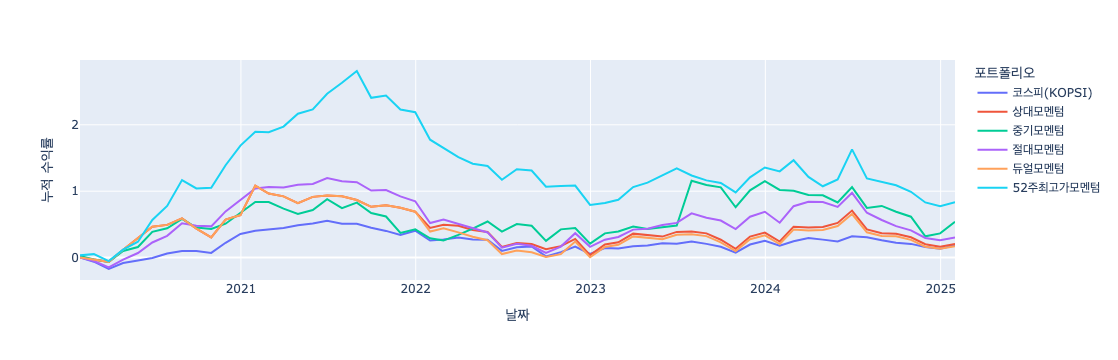

In [99]:
# cumulative return curve
# 누적 수익률 계산하기
benchmark_cum_returns = (kospi_returns + 1).cumprod() - 1
relative_cum_returns = (relative_returns + 1).cumprod() - 1
intermediate_cum_returns = (intermediate_returns + 1).cumprod() - 1
absolute_cum_returns = (absolute_returns + 1).cumprod() - 1
dual_cum_returns = (dual_returns + 1).cumprod() - 1
wh52_cum_returns = (wh52_returns + 1).cumprod() - 1

# 자산 정보 결합하기
cum_returns = pd.concat([benchmark_cum_returns, relative_cum_returns, intermediate_cum_returns,
                         absolute_cum_returns, dual_cum_returns, wh52_cum_returns], axis=1)
cum_returns.columns = ["코스피(KOPSI)", "상대모멘텀", "중기모멘텀", "절대모멘텀",
                      "듀얼모멘텀", "52주최고가모멘텀"]

# 자산 변화 시각화하기
fig = px.line(data_frame=cum_returns)

# x축, y축 레이블 설정
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='누적 수익률')

# 범례 제목 설정
fig.update_layout(legend_title_text='포트폴리오') 

fig.show()